# Problem

I used to be an actuary so my financial future is of big concern to me. I was recently really disappointed in the return of my investments and felt somewhat powerless because I don't know much about investing. I know about how much I'm going to need for my retirement, but not the details of how to get there. Being an hands-on guy I figured I could use this Project 5 opportunity to learn more about finance and see if my knowledge of machine learning can help me save on commission and make better decisions on my own. Understanding what has a significant impact on one's life is important not only to me but to everyone. If I can help those around me, my wife, my family and my friends with their investments decisions why not take a shot at it. 

The goal is not to have an automated system for trading. It is not my intention to deal with High Frequency Trading but rather provide a prediction to a human to help with financial decisions.

# Solution

This is a **regression** problem. I want to know what will be the return of an investment in the future. What will be the return over a certain period of time so I can issue a Buy or Sell order. This is not about building a diverse portfolio but rather a tool to help build it. Building the portfolio will be the next step after this project.

This could be a classification problem if I was trying to issue a Buy or Sell order, but here I want to output the return value and not an action. 

The predictions will need to be as precise as possible. Underestimating or overestimating the return of a stock will necessarily mean that the Buy/Sell decisions won't be as informed as possible. It will of course not be possible to be 100% accurate, but I think that within 5% is good enough. So if the true return is 10% then if I predict between 9.5% and 10.5% the algorithm is good enough. I don't expect such precision if the prediction is too far in the future. The further it is in the future, the less certain our predictions will be. So 5% for a 7 day forecast is my goal.


### Approach

- Two algorithms will be mainly expolored, support vector regression (SVR) and kNN.
    - I expect the returns (the object of our prediction) to be somewhat chaotic given the features I will use. kNN is a good choice for that
    - SVR is also very adaptable because of its kernel trick so it could adapt to this anticipated chaotic landscape.
- Training and testing set size will be 70/30 split in time. The testing set will be after the training set so we are not peeking into the future when training
- GridSearch will be used with Mean Squared Error (MSE) as a minimization metric. I want the model to fit as best as possible the large values of stock price changes
- Bagging will be used as well because it is less prone to overfitting. It will take the mean of every model so the overfitting will be smoothed out.
- The speed requirements for training is not that great for the current problem. I am not dealing in High Frequency Trading. A human will take a short (few days) to mid (few weeks) term decision based on the predictions.

#### High level implementation details
- The Stock object is initialized with a ticker and a period over which to calculate the return. By default it's 7 days. 
- The raw data (open, high, low, close, volume) is rescaled by dividing by their respective max values. These max values are kepts around for later transformation so the rescaling is always done the same way.
- The we can call get_data to have the examples and the targets. The examples are augmented with all the features mentioned below.
- Each predictors, SVR and kNN, have a fit and transform method to mimic the librairies provided by Scikit-learn. The fit methods split the fitting data in two sets 80/20 for cross-validation purpose. The CV set is used to select the best fit model trained over a grid of parameters.

#### Features

Many features could be interesting such as P/E Ratio and Ebitda, but those informations only come out every quarter and I'm looking at features than changes at least every day like the following:
- Volume
- Adjusted Close
- Adjusted High
- Adjusted Low
- Adjusted Open
- 10 day rolling mean and 
- 10 day rolling standard deviation (for the [Bollinger Bands](https://en.wikipedia.org/wiki/Bollinger_Bands))
- S&P500 index
- Price Volume Oscillator (PVO)
- Ratio of Exponential Mean Average (EMA) of 10, 25 and 50 days over EMA of 100 days
- Kama
- Relative Strength Index (RSI)
- Ichimoku Cloud which is composed of many indicators: tenkansen, kijunsen, senkouA, senkouB, chikou
- Chandelier which has two indicators: Highest High and Lowest Low over the last 22 days
- Average True Ratio

Most of these indicators come from this website
http://stockcharts.com/school/doku.php?%20%20%20%20id=chart_school:technical_indicators

#### Target
- Return over X days $\left(\frac{price_{t+x}}{price_{t}} - 1\right)$

#### Data Source
- Quandl API
- Yahoo Finance

### Package Requirements
- numpy:           1.10.2
- pandas:          0.17.1
- python-dateutil: 2.4.2
- pytz:            2015.7
- quandl:          2.8.9
- requests:        2.9.0
- six:             1.10.0
- scikit-learn:    0.17
- scipy:           0.16.1

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from predictor import SVRPredictor, Stock, KNNPredictor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

### SVR

> SVR models are fitted over a grid search and boosting. Training time is about 5 minutes but as I mentioned above it is of no big concerns since we are not dealing in high frequency traiding.

In [13]:
svr = SVRPredictor(['AAPL'], 7)
svr.fit(start_date='2014-01-01', end_date='2015-10-31')

In [14]:
m = svr.models['AAPL']
m

AdaBoostRegressor(base_estimator=SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=1e-05, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
         learning_rate=1.0, loss='linear', n_estimators=50,
         random_state=None)

In [15]:
predictions = svr.transform(['AAPL'], start_date='2015-11-01', end_date='2015-12-31')

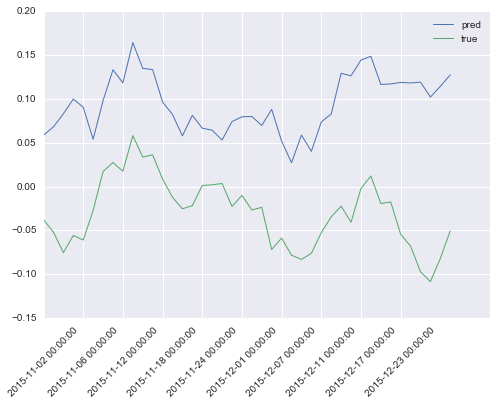

In [16]:
y_pred, y_true = predictions['AAPL']
plt.plot(range(0,len(y_pred)), y_pred, linewidth=1)
plt.plot(range(0,len(predictions['AAPL'][1])), predictions['AAPL'][1], linewidth=1)
plt.xticks(4*np.arange(len(y_pred)/4), y_pred.index[::4], rotation=45)
# plt.plot(range(0,len(y_pred)), np.array(y_pred) - np.array(y_true), linewidth=1)
plt.legend(['pred', 'true'])

In [17]:
((y_pred-y_true)**2).mean()**0.5

0.12993262002323028

Now we see that the prediction curve is following the true curve quite well but it's off. It would be tempting to just shift the prediction curve by a certain amount $\delta$ to get really close to the true curve. Eyeballing it we see that they would be a really close match. But the problem resides in this $\delta$. If I were to predict the return tomorrow, I would have no idea how much that $\delta$ should be. I would be blind by not knowing what the true curve is.

That being said, as of today at the closing market I know the actual return over the last 7 days period. Wouldn't that true historical curve provide a good starting point for our estimate? Let's try just that. Get the last return over the training period and use that as starting point.

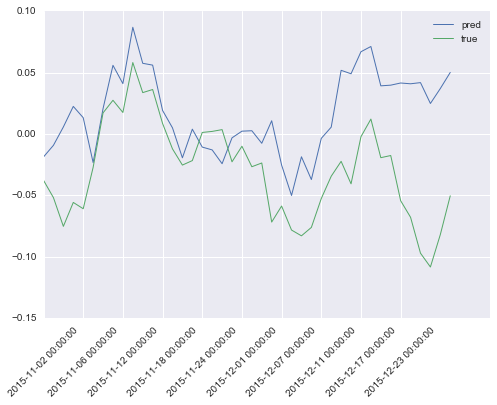

In [20]:
# Get the initial starting point of the training period
stock = Stock('AAPL')
data, label = stock.get_data(start_date='2014-01-01', end_date='2015-10-31', fit=True)
delta = y_pred.values[0] - label.values[-1]

plt.plot(range(0,len(y_pred)), y_pred - delta, linewidth=1)
plt.plot(range(0,len(predictions['AAPL'][1])), predictions['AAPL'][1], linewidth=1)
plt.xticks(4*np.arange(len(y_pred)/4), y_pred.index[::4], rotation=45)
plt.legend(['pred', 'true'])

In [21]:
(((y_pred-delta)-y_true)**2).mean()**0.5

0.06107687423111014

They are now much closer and the RMSE is much lower than before. Let's try that with another company, say Google (GOOGL)

In [22]:
svr = SVRPredictor(['GOOGL'], 7)
svr.fit(start_date='2014-01-01', end_date='2015-10-31')

In [23]:
predictions = svr.transform(['GOOGL'], start_date='2015-11-01', end_date='2015-12-31')

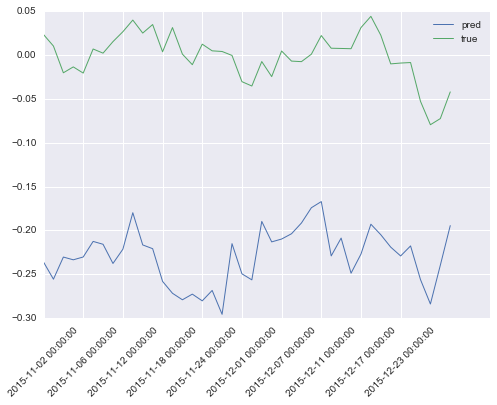

In [24]:
y_pred, y_true = predictions['GOOGL']
plt.plot(range(0,len(y_pred)), y_pred, linewidth=1)
plt.plot(range(0,len(predictions['GOOGL'][1])), predictions['GOOGL'][1], linewidth=1)
plt.xticks(4*np.arange(len(y_pred)/4), y_pred.index[::4], rotation=45)
# plt.plot(range(0,len(y_pred)), np.array(y_pred) - np.array(y_true), linewidth=1)
plt.legend(['pred', 'true'])

In [26]:
((y_pred-y_true)**2).mean()**0.5

0.23070147068002114

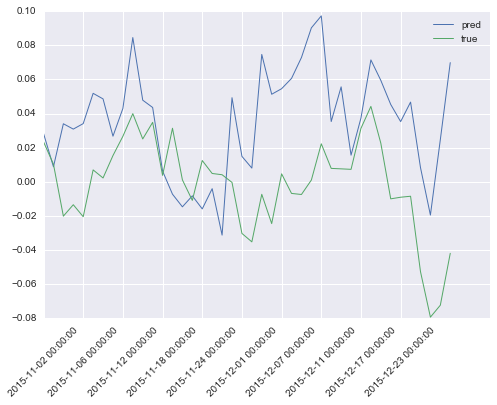

In [27]:
y_pred, y_true = predictions['GOOGL']

stock = Stock('GOOGL')
data, label = stock.get_data(start_date='2014-01-01', end_date='2015-10-31', fit=True)
delta = y_pred.values[0] - label.values[-1]

plt.plot(range(0,len(y_pred)), y_pred - delta, linewidth=1)
plt.plot(range(0,len(predictions['GOOGL'][1])), predictions['GOOGL'][1], linewidth=1)
plt.xticks(4*np.arange(len(y_pred)/4), y_pred.index[::4], rotation=45)
# plt.plot(range(0,len(y_pred)), np.array(y_pred) - np.array(y_true), linewidth=1)
plt.legend(['pred', 'true'])

In [28]:
(((y_pred - delta)-y_true)**2).mean()**0.5

0.05059649921588711

### kNN

> kNN models are also boosted and hyperparameter tuning through cross validation. Mostly it is just selecting k.

In [4]:
knn = KNNPredictor(['AAPL'], 7)
knn.fit(start_date='2015-01-01', end_date='2015-10-31')

                Open      High       Low    Volume  Adjusted Close  SP Close  \
Date                                                                           
2015-01-02  0.825168  0.825048  0.810375  0.328006        0.818223  0.965919   
2015-01-05  0.802204  0.804392  0.795730  0.396319        0.795172  0.948264   
2015-01-06  0.789240  0.795360  0.789842  0.405638        0.795247  0.939831   
2015-01-07  0.794129  0.801060  0.805468  0.247252        0.806398  0.950761   
2015-01-08  0.809167  0.830304  0.820566  0.365981        0.837382  0.967768   

                 ATR  r_mean10   r_std10  r_high22    ...     senkouB52  \
Date                                                  ...                 
2015-01-02  0.011224  0.839739  0.010833  0.867617    ...      0.816985   
2015-01-05  0.012439  0.834949  0.017644  0.867617    ...      0.827082   
2015-01-06  0.012178  0.830818  0.021615  0.864324    ...      0.829020   
2015-01-07  0.011327  0.826934  0.022217  0.860657    ...      0

In [5]:
knn.models['AAPL']

AdaBoostRegressor(base_estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=15, p=2,
          weights='uniform'),
         learning_rate=1.0, loss='linear', n_estimators=50,
         random_state=None)

In [6]:
predictions = knn.transform(['AAPL'], start_date='2015-11-01', end_date='2015-12-31')

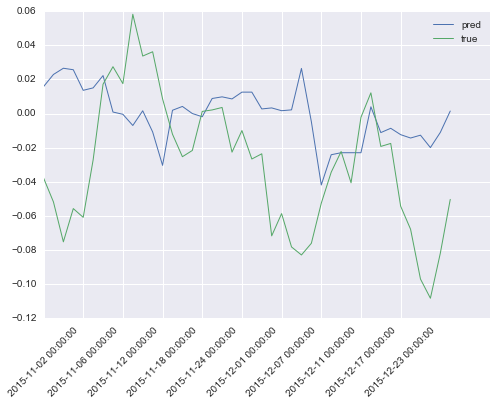

In [7]:
y_pred, y_true = predictions['AAPL']
plt.plot(range(0,len(y_pred)), y_pred, linewidth=1)
plt.plot(range(0,len(predictions['AAPL'][1])), predictions['AAPL'][1], linewidth=1)
plt.xticks(4*np.arange(len(y_pred)/4), y_pred.index[::4], rotation=45)
# plt.plot(range(0,len(y_pred)), np.array(y_pred) - np.array(y_test), linewidth=1)
plt.legend(['pred', 'true'])

In [8]:
((y_pred-y_true)**2).mean()**0.5

0.051041226828708645

Without shifting anything, as attempted in SVR, kNN is already doing better from the RMSE standpoint. Let's still entertain the idea by shifting by the appropriate $\delta$

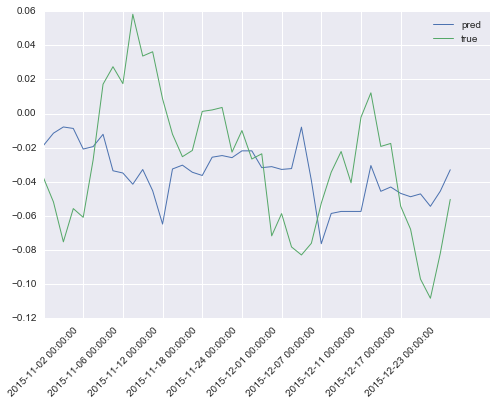

In [9]:
# Get the initial starting point of the training period
stock = Stock('AAPL')
data, label = stock.get_data(start_date='2014-01-01', end_date='2015-10-31', fit=True)
delta = y_pred.values[0] - label.values[-1]

plt.plot(range(0,len(y_pred)), y_pred - delta, linewidth=1)
plt.plot(range(0,len(predictions['AAPL'][1])), predictions['AAPL'][1], linewidth=1)
plt.xticks(4*np.arange(len(y_pred)/4), y_pred.index[::4], rotation=45)
plt.legend(['pred', 'true'])

In [10]:
(((y_pred-delta)-y_true)**2).mean()**0.5

0.04245201177421414

So the $\delta$ shifting also improves the results here but not as much. From a graphical perspective kNN seems to be doing worst that SVR but the RMSE is better.

# Conclusion

### Domain Knowledge Expert

Feature engineering played a large part of this research. Some would say that this is the single most important part of using machine learning. With the help of trader friend I was iterating through different features based on what they look on a day to day basis. No doubt that working closely with an expert in the field would help the feature engineering part.

### Problem Definition

The problem could have been formulated differently. Instead of trying to predict the return over a period of time, 7 days in this case, and treating it as a regression problem it could be done as a classification problem where we just try to predict if the stock is gonna go up or down. By the very nature of stock trading the price is very volatile and quite unpredictable. Reducing it to a classification problem could simplify the problem.

As briefly mention, stock prices are volatile. Another thing that could be done to remove part of that volatility is to try to predict what the moving average would be. The label would be much smoother this way and large variations would occur less often.

### Model of choice

One would instinctively chose SVR because it fits the curve much better than kNN, regardless of the RMSE. But kNN has an intrinsic property of giving the volatility of the predictions. The standard deviation of the k points could represent our uncertainty about our own predictions. This is a huge comforting advantage to the user to get a confidence measure because in the end a human will make the decision to buy or sell a stock.

### Delta

Using the $\delta$ trick is bringing the RMSE much closer to my goal of 5%. I have never seen that in any blog post or paper and it makes it really hard to know if